In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from scipy import interpolate
from time import sleep
from tqdm import tqdm
import seaborn as sns
import torch.nn.functional as F
import matplotlib.ticker as ticker
from scipy.stats import norm

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [1]:
def Cumulative(wave):
    cu_list = []
    lists = wave.tolist()[0]
    length = len(lists)
    lists = [i**2 for i in lists]
    cu_list = [sum(lists[0:x:1]) for x in range(0, length+1)]
    return np.array(cu_list[1:])

def FindValueIndex(seq, val):
    r = np.where(np.diff(np.sign(seq - val)) != 0)
    idx = r + (val - seq[r]) / (seq[r + np.ones_like(r)] - seq[r])
    idx = np.append(idx, np.where(seq == val))
    idx = np.sort(idx)
    return np.round(idx)

def FindTOF(wave):
  Ts = 2e-7
  Threshold = 0.25
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Time_response[index]) if val > 145e-6)

  return TOF*1e6

def FindTOF_longwindow(wave):
  Ts = 2e-7
  Threshold = 0.25
  Long_response = np.arange(145e-6, 225e-6+Ts/2, Ts)
  Cum_Amp_1 = Cumulative(wave)
  Cum_Amp_1_t = np.gradient(Cum_Amp_1,Ts*1e6)
  Target_Amp = np.max(Cum_Amp_1_t)*Threshold
  index = FindValueIndex(Cum_Amp_1_t,Target_Amp).astype(int)
  TOF = next(val for x, val in enumerate(Long_response[index]) if val > 154e-6)
  return TOF*1e6

# GenerateSine(Peak-peak Amplitude,frequency,cycles)
def GenerateSine(A,freq,cycles):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  return Amp

def GenerateNoisySine(A,freq,cycles,sigma):
  t = np.linspace(0, 50e-6, 251)
  Time = np.arange(0, cycles/freq/1e3, 2e-7)
  Amp = A / 2 * np.sin(2*np.pi*freq*1e3*Time)
  noise_sigma = np.std(Amp)*sigma
  Amp = np.append(Amp,np.zeros(251-len(Time)))
  Amp = Amp + np.random.normal(0,noise_sigma,len(Amp))
  return Amp

# consider the specific heat ratio
def Cal_percentage(t_A,M_B,delta_t,gas):
    if gas == 'Air':
      k_B = 1.4 # air
    elif gas == 'Argon':
      k_B = 1.66 # argon
    M_A =  4.002602 #  Gas A: helium [g/mol]
    k_A = 1.66
    M_ratio = (M_B-M_A)/M_A
    t_ratio = (t_A/(t_A+delta_t))**2
    nume = k_A * (1-t_ratio)
    denu = t_ratio*k_A*M_ratio-k_B+k_A
    percentage = nume/denu # percentage (minus means delay)
    return percentage*100

def Cal_deltaTOF(con_argon,con_air,T,L):

    R = 8.314 # individual gas constant (J/mol*K)
    #T = 550 # absolute temperature (K)
    #L = 1600 # [mm]
    t_A = L / np.sqrt(1.66*R*T/(4.002602/1e3)) * 1e3
    k_M = (1.66*(100-con_argon-con_air)+1.667*con_argon+1.4*con_air)/100
    M_M = (4.002602*(100-con_argon-con_air)+39.948*con_argon+28.966*con_air)/100/1e3 # kg/mol
    c_M = np.sqrt(k_M*R*T/M_M)
    return (L / c_M * 1e3-t_A)

def CalVolume(array,time,gas):
    MFC_Helium = 0.1646 #(sl/s) / V
    MFC_Air = 118.56  #(sccm/s) / V

    interval = time / len(array)
    if gas == 'Helium':
        volume = np.trapz(array * MFC_Helium, dx=interval)
    elif gas == 'Air':
        volume = np.trapz(array * MFC_Air, dx=interval)
    return(volume)

def compute_normalized_stft(signal, fs, window_size, overlap, max_frequency):
    frequencies, times, Zxx = stft(signal, fs=fs, window='hann', nperseg=window_size, noverlap=overlap)
    magnitude = np.abs(Zxx)

    max_freq_idx = np.argmax(frequencies > max_frequency)
    magnitude = magnitude[:max_freq_idx, :]

    magnitude_db = 20 * np.log10(np.maximum(magnitude, 1e-8))
    #magnitude_min = np.min(magnitude_db)
    #magnitude_max = np.max(magnitude_db)
    #magnitude_normalized = (magnitude_db - magnitude_min) / (magnitude_max - magnitude_min)

    return magnitude_db

def find_closest_con_air(con_argon, delta_TOF_truth):
    con_air_range = np.linspace(0, 1.2, 500)
    delta_TOFs = [Cal_deltaTOF(con_argon, con_air) for con_air in con_air_range]
    idx = np.argmin(np.abs(np.array(delta_TOFs) - delta_TOF_truth))
    return con_air_range[idx]

# Data Pre-processing

Read Excitations

In [ ]:
Excitation_set = []

In [ ]:
Ts = 2e-7
Time_exci = np.arange(0, 50e-6+Ts/2, Ts)
Time_exci

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/500khz

for n in range(275):
  x = np.loadtxt('C1--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")
  t0_index = np.argmin(abs(x[:,0]))
  t_end = np.argmin(abs(x[:,0]-50e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Excitation = interpolator(Time_exci)

  Excitation_set.append(list(Interpolated_Excitation))

/content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/500khz


In [ ]:
Excitation_set = np.array(Excitation_set)

In [ ]:
np.save('Excitation_set.npy',Excitation_set)

In [ ]:
test = GenerateSine(0.4,500,10)

In [ ]:
from matplotlib import rcParams
plt.figure(figsize=(3,3),dpi=100)  # Figure size
mpl.rcParams.update({'font.size': 14})  # Global font size

idx = 26141

Time_plot = np.arange(0, 85e-6+Ts/2, Ts)
plt.plot(Time_plot*1e6,Response_test[idx:idx+1,426:].reshape(-1,1),linewidth=2,color='red')
#plt.plot(Time_exci*1e6,test.reshape(-1,1),linewidth=2,color='b')

plt.title('Excitation',fontsize=14)
plt.xlabel ('Time / us')
plt.ylabel ('Amplitude / V')
plt.ylim(-1,1)
plt.xlim(0,50)

Read Responses

In [ ]:
Response_set = []

In [ ]:
Time_response = np.arange(145e-6, 215e-6+Ts/2, Ts)

Time_response

In [ ]:
%cd /content/gdrive/MyDrive/AME508/Helium-Data/Training_data_pure_helium/600khz

for n in range(228):
  x = np.loadtxt('C2--Trace-Helium-15cm--00'+str(f"{n:03}")+'.csv',dtype='float32',skiprows=5,delimiter=",")

  t0_index = np.argmin(abs(x[:,0]-145e-6))
  t_end = np.argmin(abs(x[:,0]-215e-6))

  interpolator = interpolate.interp1d(x[t0_index:t_end,0], x[t0_index:t_end,1],kind='linear',fill_value=0,bounds_error=False)
  Interpolated_Response = interpolator(Time_response)

  Response_set.append(list(Interpolated_Response))

In [ ]:
Response_set = np.array(Response_set)

In [ ]:
np.save('Response_set.npy',Response_set)

In [ ]:
plt.figure(figsize=(30,5),dpi=100)  # Figure size
mpl.rcParams.update({'font.size': 14})  # Global font size

plt.plot(Time_response*1e6,X_train[5:6,:].reshape(-1,1),linewidth=3,color='b',alpha=0.7)
#plt.xlabel (r"Time / $\it{\mu}$s"),plt.xlim(1000,1300)
#plt.ylabel ('Amplitude / V')
#plt.title('Response',fontsize=14)
plt.axis('off')
plt.ylim(-1,1)

# Load Pre-processed Data (Please RUN FROM HERE)

In [ ]:
%cd /content/gdrive/MyDrive/CNN-Autoencoder-Impurity/FAN_Argon

X_train = np.load('X_train_helium(argon).npy')
Argon_Percentage = np.load('Argon_Percentage.npy')
Ts = 1e-6 # sampling interval
Time_response = np.arange(1000e-6, 1300e-6+Ts/2, Ts)

data = np.load("impurity_data.npz")
impurity_data_argon = {key: data[key] for key in data}

/content/gdrive/MyDrive/CNN-Autoencoder-Impurity/FAN_Argon


In [ ]:
%cd /content/gdrive/MyDrive/CNN-Autoencoder-Impurity/FAN_Air

X_train_1 = np.load('X_train_helium(air).npy')
X_train = np.vstack((X_train,X_train_1))
Air_Percentage = np.load('Air_Percentage.npy')

data = np.load("impurity_data.npz")
impurity_data_air = {key: data[key] for key in data}

/content/gdrive/MyDrive/CNN-Autoencoder-Impurity/FAN_Air


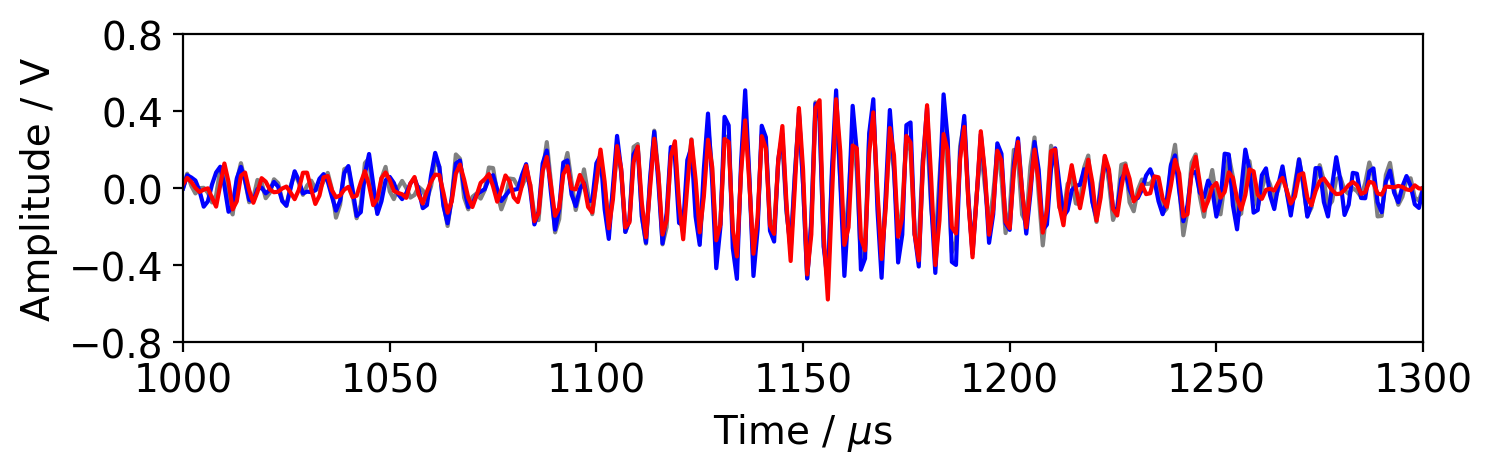

In [ ]:
plt.figure(figsize=(8,2),dpi=200)

plt.plot(Time_response*1e6,X_train[1500,:],linestyle='-', color='grey',markerfacecolor='white',label='Benchmark 1')
plt.plot(Time_response*1e6,X_train[1300,:],linestyle='-', color='b', markerfacecolor='white',label='Benchmark 2')
plt.plot(Time_response*1e6,X_train[1600,:],linestyle='-', color='r', markerfacecolor='white',label='Benchmark 3')

#plt.plot(Time_response*1e6,row_means,linestyle='-', color='k', alpha=0.8,markerfacecolor='white',label='')

plt.xlabel (r"Time / $\it{\mu}$s",fontsize=14)
plt.ylabel('Amplitude / V',fontsize=14)
#plt.legend(bbox_to_anchor=(0.95, 1.3),edgecolor='k',fontsize='large',frameon=True,ncol=3)
plt.xlim(1000,1300)
plt.ylim(-0.8,0.8)
plt.yticks(np.arange(-0.8, 1.2, 0.4))
#plt.xticks(np.arange(0, 1.8, 0.2))
plt.tick_params(axis='both', labelsize=14)
plt.show()

# Subtration method

In [ ]:
def delay_and_analyze_burst(delay_time, frequency=225e3, sampling_rate=1e6, cycles=20):
    timeline = np.arange(0, 300e-6, 1/sampling_rate)
    burst_1 = np.sin(2 * np.pi * frequency * timeline) * (timeline < cycles/frequency)
    combined_burst_1 = np.hstack((timeline.reshape(-1,1), burst_1.reshape(-1,1)))

    if delay_time ==0:
      delayed_burst_1 = burst_1
    else:
      sample_delay = int(delay_time * sampling_rate)
      delayed_burst_1 = np.hstack((np.zeros(sample_delay), burst_1[:-sample_delay]))

    # Combining with the same timeline
    combined_delayed_burst_1 = np.hstack((timeline.reshape(-1, 1), delayed_burst_1.reshape(-1, 1)))

    # Calculating the subtraction of the delayed burst from the original burst
    Subtraction = combined_delayed_burst_1[:,1] - combined_burst_1[:,1]
    combined_subtraction = np.hstack((timeline.reshape(-1, 1), Subtraction.reshape(-1, 1)))

    # Calculating the L1 norm of the subtraction
    L1_norm = np.sum(np.abs(combined_subtraction[:,1]))

    return combined_burst_1, combined_delayed_burst_1, combined_subtraction, L1_norm

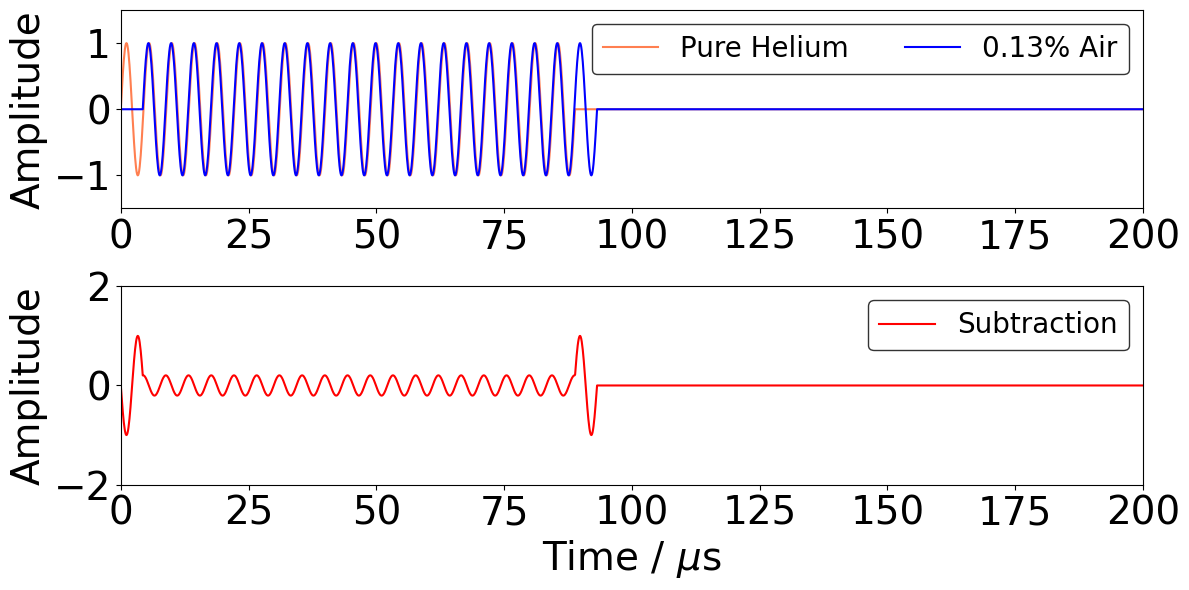

In [ ]:
#undelay_signal, delay_signal, subtraction, norm = delay_and_analyze_burst(Cal_deltaTOF(Argon_Percentage[3], 0, 294, 1066.8)*1e-6)
undelay_signal, delay_signal, subtraction, norm = delay_and_analyze_burst(Cal_deltaTOF(0,very_low_concen_air[13], 294, 1066.8)*1e-6,sampling_rate=1e7)

# Creating a 2 by 1 subplot
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

# Plotting undelayed and delayed signals in the first subplot
axs[0].plot(undelay_signal[:,0]*1e6, undelay_signal[:,1], label='Pure Helium',color='coral')
axs[0].plot(delay_signal[:,0]*1e6, delay_signal[:,1], label=f'0.13% Air',color='b')
axs[0].legend(loc='upper right',edgecolor='k',fontsize=20,frameon=True,ncol=2)
axs[0].tick_params(axis='both', labelsize=28)
axs[0].set_ylabel('Amplitude',fontsize=28)
axs[0].set_xlim(0,200)
axs[0].set_ylim(-1.5,1.5)

# Plotting the subtraction in the second subplot
axs[1].plot(subtraction[:,0]*1e6, subtraction[:,1], label='Subtraction',color='r')
axs[1].legend(loc='upper right',edgecolor='k',fontsize=20,frameon=True,ncol=1)
axs[1].set_xlabel (r"Time / $\it{\mu}$s",fontsize=28)
axs[1].set_ylabel('Amplitude',fontsize=28)

axs[1].set_xlim(0,200)
axs[1].set_ylim(-2,2)

#plt.yticks(np.arange(-0.8, 1.2, 0.4))
#plt.xticks(np.arange(0, 1.8, 0.2))
axs[1].tick_params(axis='both', labelsize=28)
axs[0].tick_params(axis='both', labelsize=28)

plt.tight_layout()
plt.show()

In [ ]:
import imageio

# Function to plot each signal
def plot_signal(signal, index, sampling_rate,gas):
  if gas == 'Argon':
    undelay_signal, delay_signal, subtraction, norm = delay_and_analyze_burst(Cal_deltaTOF(signal, 0, 294, 1066.8)*1e-6, sampling_rate=sampling_rate)
  if gas == 'Air':
    undelay_signal, delay_signal, subtraction, norm = delay_and_analyze_burst(Cal_deltaTOF(0, signal, 294, 1066.8)*1e-6, sampling_rate=sampling_rate)
  # Creating a 2 by 1 subplot
  fig, axs = plt.subplots(2, 1, figsize=(12, 6))

  # Plotting undelayed and delayed signals in the first subplot
  axs[0].plot(undelay_signal[:,0]*1e6, undelay_signal[:,1], label='Benchmark Signal',color='coral')
  axs[0].plot(delay_signal[:,0]*1e6, delay_signal[:,1], label=f'Delayed Signal',color='b')
  axs[0].legend(loc='upper right',edgecolor='k',fontsize='large',frameon=True,ncol=1)
  axs[0].tick_params(axis='both', labelsize=16)
  axs[0].set_ylabel('Amplitude',fontsize=16)
  axs[0].set_xlim(0,200)
  axs[0].set_ylim(-1.5,1.5)

  # Plotting the subtraction in the second subplot
  axs[1].plot(subtraction[:,0]*1e6, subtraction[:,1], label='Subtraction',color='r')
  axs[1].legend(loc='upper right',edgecolor='k',fontsize='large',frameon=True,ncol=1)
  axs[1].set_xlabel (r"Time / $\it{\mu}$s",fontsize=16)
  axs[1].set_ylabel('Amplitude',fontsize=16)

  axs[1].set_xlim(0,200)
  axs[1].set_ylim(-2,2)

  #plt.yticks(np.arange(-0.8, 1.2, 0.4))
  #plt.xticks(np.arange(0, 1.8, 0.2))
  axs[1].tick_params(axis='both', labelsize=16)

  #plt.tight_layout()
  #plt.show()

  plt.savefig(f"argon_plot_{index}.png")
  plt.close()

# Plot each signal and save as an image
for i, signal in enumerate(very_low_concen_argon):
    plot_signal(signal, i, 1e7,'Argon')

In [ ]:
# Create GIF
images = []
for i in range(len(very_low_concen_argon)):
    images.append(imageio.v2.imread(f"argon_plot_{i}.png"))

imageio.mimsave('GIF-argon.gif',images, format='GIF',duration=10)  # Adjust duration as needed

In [ ]:
#delays = Cal_deltaTOF(Argon_Percentage, 0, 294, 1066.8)*1e-6
delays = Cal_deltaTOF(0, Air_Percentage, 294, 1066.8)*1e-6

all_norms = []
for delay in delays:
  undelay_signal, delay_signal, subtraction, norm = delay_and_analyze_burst(delay,sampling_rate=1e7)
  all_norms.append(norm)

<ipython-input-7-f1246c8a9b35>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_delay = int(delay_time * sampling_rate)


higher concentrations

In [ ]:
higher_concen_air = np.arange(1.3,3,0.03).reshape(-1,1)
longer_percentage_air = np.vstack((Air_Percentage,higher_concen_air))

higher_concen_argon = np.arange(1.55,3,0.04).reshape(-1,1)
longer_percentage_argon = np.vstack((Argon_Percentage,higher_concen_argon))

#delays = Cal_deltaTOF(higher_concen_argon, 0, 294, 1066.8)*1e-6
delays = Cal_deltaTOF(0, higher_concen_air, 294, 1066.8)*1e-6

all_norms_predict = []

for delay in delays:
  undelay_signal, delay_signal, subtraction, norm = delay_and_analyze_burst(delay,sampling_rate=1e7)
  all_norms_predict.append(norm)

<ipython-input-7-f1246c8a9b35>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_delay = int(delay_time * sampling_rate)


very low concentrations

In [ ]:
very_low_concen_air = np.arange(0,0.2,0.01).reshape(-1,1)
very_low_concen_argon = np.arange(0,0.2,0.01)

#delays = Cal_deltaTOF(very_low_concen_argon, 0, 294, 1066.8)*1e-6
delays = Cal_deltaTOF(0, very_low_concen_air, 294, 1066.8)*1e-6

very_low_norms_predict = []

for delay in delays:
  undelay_signal, delay_signal, subtraction, norm = delay_and_analyze_burst(delay,sampling_rate=1e7)
  very_low_norms_predict.append(norm)

<ipython-input-7-f1246c8a9b35>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_delay = int(delay_time * sampling_rate)


In [ ]:
l1_norms = []
for i in range(1, 41):
    subtract = np.mean(impurity_data_air[f'Impurity_Air_{i}'], axis=0) - np.mean(X_train[1003:], axis=0)
    #subtract = np.mean(impurity_data_argon[f'Impurity_Argon_{i}'], axis=0) - np.mean(X_train[:1003], axis=0)

    l1_norm = np.linalg.norm(subtract,ord=1) #L1 norm
    l1_norms.append(l1_norm)

# Storing all norms in one variable
l1_norms = np.array(l1_norms)
l1_norms = np.insert(l1_norms, 0, 0)

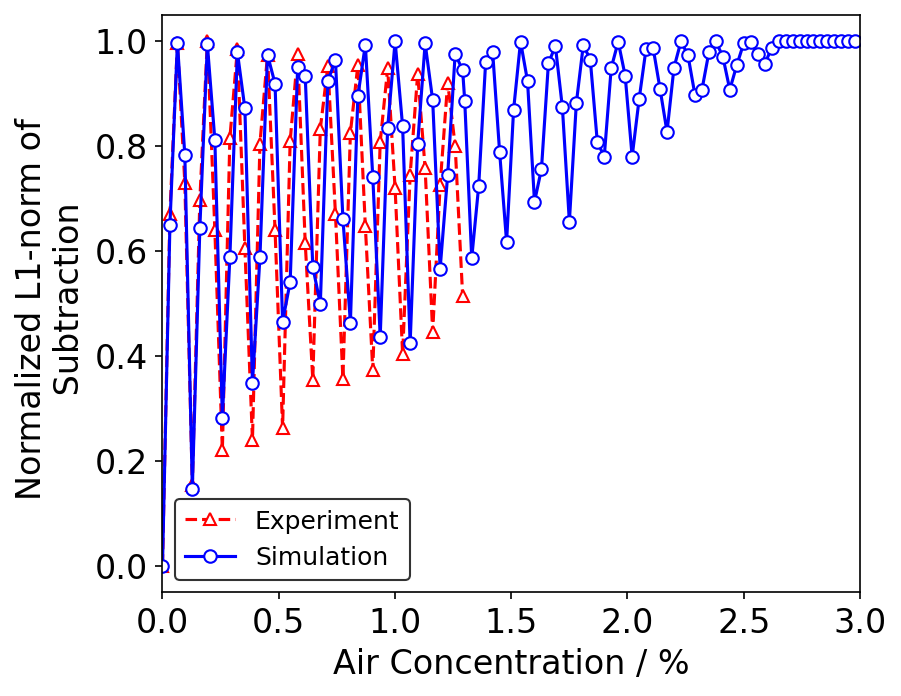

In [ ]:
l1_norms_normalized = l1_norms / np.max(l1_norms) #experiment

norm_pre = all_norms+all_norms_predict
all_norms_pre_normalized = norm_pre / np.max(norm_pre)
very_low_normalized = very_low_norms_predict / np.max(very_low_norms_predict)

#pre_all_concen = np.vstack((Argon_Percentage,higher_concen_argon))
pre_all_concen = np.vstack((Air_Percentage,higher_concen_air))

plt.figure(figsize=(6,5),dpi=150)

plt.plot(Air_Percentage,l1_norms_normalized,linestyle='--',marker='^', color='r', markerfacecolor='white',label='Experiment')
plt.plot(pre_all_concen, all_norms_pre_normalized, linestyle='-', marker='o', color='b', markerfacecolor='white', label='Simulation')

#plt.plot(very_low_concen_argon, very_low_normalized, linestyle='-', marker='o', color='b',linewidth=4, markersize=10,markerfacecolor='white', label='Simple Simulation',zorder=1)
#plt.scatter(Argon_Percentage,l1_norms_normalized,marker='^', color='r', s=300, facecolors='white',label='Experiment',lw=2)

# Setting labels and title
plt.xlabel('Air Concentration / %',fontsize=16)
plt.ylabel('Normalized L1-norm of \n Subtraction',fontsize=16)
plt.legend(loc='lower left',edgecolor='k',fontsize='large',frameon=True,ncol=1)
plt.xlim(0,3)
#plt.ylim(0,7)
#plt.yticks(np.arange(0, 0.18, 0.03))
#plt.xticks(np.arange(0, 1.8, 0.2))
plt.tick_params(axis='both', labelsize=16)
plt.show()

In [ ]:
pre_all_concen[np.where(all_norms_pre_normalized == 1.0)[0][0]]

array([2.71])

# Create custom dataset class

In [ ]:
class DataSet(torch.utils.data.Dataset):
  def __init__(self, ds):
    self.data = ds

  def __len__(self):
    return len(self.data[:,:])

  def __getitem__(self, idx):
    data = self.data[idx]
    return data

# Create dataset generator

In [ ]:
# Generators
batch_size = 32
trainingData = DataSet(X_train_with_TOF)
training_generator = torch.utils.data.DataLoader(trainingData,batch_size=batch_size,shuffle=True)

# Build and Train Neural Network

In [ ]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()

        # Encoder
        self.conv1 = nn.Conv1d(1, 4, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(4, 8, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1)

        self.fc_enc = nn.Linear(16*38, 10)
        self.fc_dec = nn.Linear(10, 16*38)

        # Decoder
        self.deconv1 = nn.ConvTranspose1d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose1d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.deconv3 = nn.ConvTranspose1d(4, 1, kernel_size=3, stride=2, padding=1, output_padding=0)  # Adjusted output_padding

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc_enc(x))

        # Decoder
        x = F.relu(self.fc_dec(x))
        x = x.view(x.size(0), 16, 38)  # Reshape
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = self.deconv3(x)

        return x

from torchsummary import summary

summary(CNNAutoencoder(), input_size=(1, 301))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 151]              16
            Conv1d-2                [-1, 8, 76]             104
            Conv1d-3               [-1, 16, 38]             400
            Linear-4                   [-1, 10]           6,090
            Linear-5                  [-1, 608]           6,688
   ConvTranspose1d-6                [-1, 8, 76]             392
   ConvTranspose1d-7               [-1, 4, 151]             100
   ConvTranspose1d-8               [-1, 1, 301]              13
Total params: 13,803
Trainable params: 13,803
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.05
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(302, 20) # 302: 301 signals + 1 TOF
        self.fc_mu = nn.Linear(20, 10) # 10 for mu and 10 for logvar
        self.fc_logvar = nn.Linear(20, 10)
        # Decoder
        self.fc3 = nn.Linear(10, 302)
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        return self.fc3(z)
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 302))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function
beta = 1
alpha = 0.1
def loss_function(recon_x, x, mu, logvar):
    #BCE_signal = F.mse_loss(recon_x[:,:-1], x.view(-1, 302)[:,:-1], reduction='sum')
    BCE_signal = F.l1_loss(recon_x[:,:-1], x.view(-1, 302)[:,:-1],reduction='sum')
    BCE_TOF = F.mse_loss(recon_x[:,-1], x.view(-1, 302)[:,-1],reduction='sum') # always return one value, during training it's across signal length and batch size
    BCE_total = BCE_signal + alpha * BCE_TOF

    # KL Divergence
    KLD = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar)
    return BCE_total + beta * KLD,BCE_signal,alpha * BCE_TOF

In [ ]:
from torchsummary import summary

summary(VAE(),input_size=(1,302))

# Training

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# create the model
vae = VAE().to(device)

max_epochs = 500
optimizer = optim.Adam(vae.parameters(), lr=5e-5, betas=(0.9, 0.999))
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

train_loss = []
signal_loss_list = []
TOF_loss_list = []

for epoch in tqdm(range(max_epochs)):
  for index, data in enumerate(training_generator):

    inputs_train = data[:,:].to(torch.float32).to(device)
    #inputs_train = torch.reshape(inputs_train, (inputs_train.size(dim=0), 1, 301))
    groundtruth_train = data[:,:].reshape(-1,1).to(torch.float32).to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # make prediction and evaluate loss
    prediction = vae(inputs_train)

    # evaluate loss
    tran_loss = loss_function(prediction[0],groundtruth_train,prediction[1],prediction[2])[0]
    signal_loss = loss_function(prediction[0],groundtruth_train,prediction[1],prediction[2])[1]
    TOF_loss = loss_function(prediction[0],groundtruth_train,prediction[1],prediction[2])[2]

    # find the gradients using back-propagation
    tran_loss.backward()

    # update the weights
    optimizer.step()

  train_loss.append(tran_loss.item()) # ONLY last batch!!
  signal_loss_list.append(signal_loss.item()) # ONLY last batch!!
  TOF_loss_list.append(TOF_loss.item()) # ONLY last batch!!

  sleep(0)

cpu


100%|██████████| 500/500 [02:15<00:00,  3.69it/s]


In [ ]:
PATH = './VAE-TOF.pth'
torch.save(vae.state_dict(), PATH)

In [ ]:
%cd /content/gdrive/MyDrive/CNN-Autoencoder-Impurity

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

PATH = './VAE-TOF.pth'

# create the model
vae = VAE().to(device)

vae.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

/content/gdrive/MyDrive/CNN-Autoencoder-Impurity
cpu


<All keys matched successfully>

# Visualization

In [ ]:
print(train_loss[-1])
print(test_loss[-1])

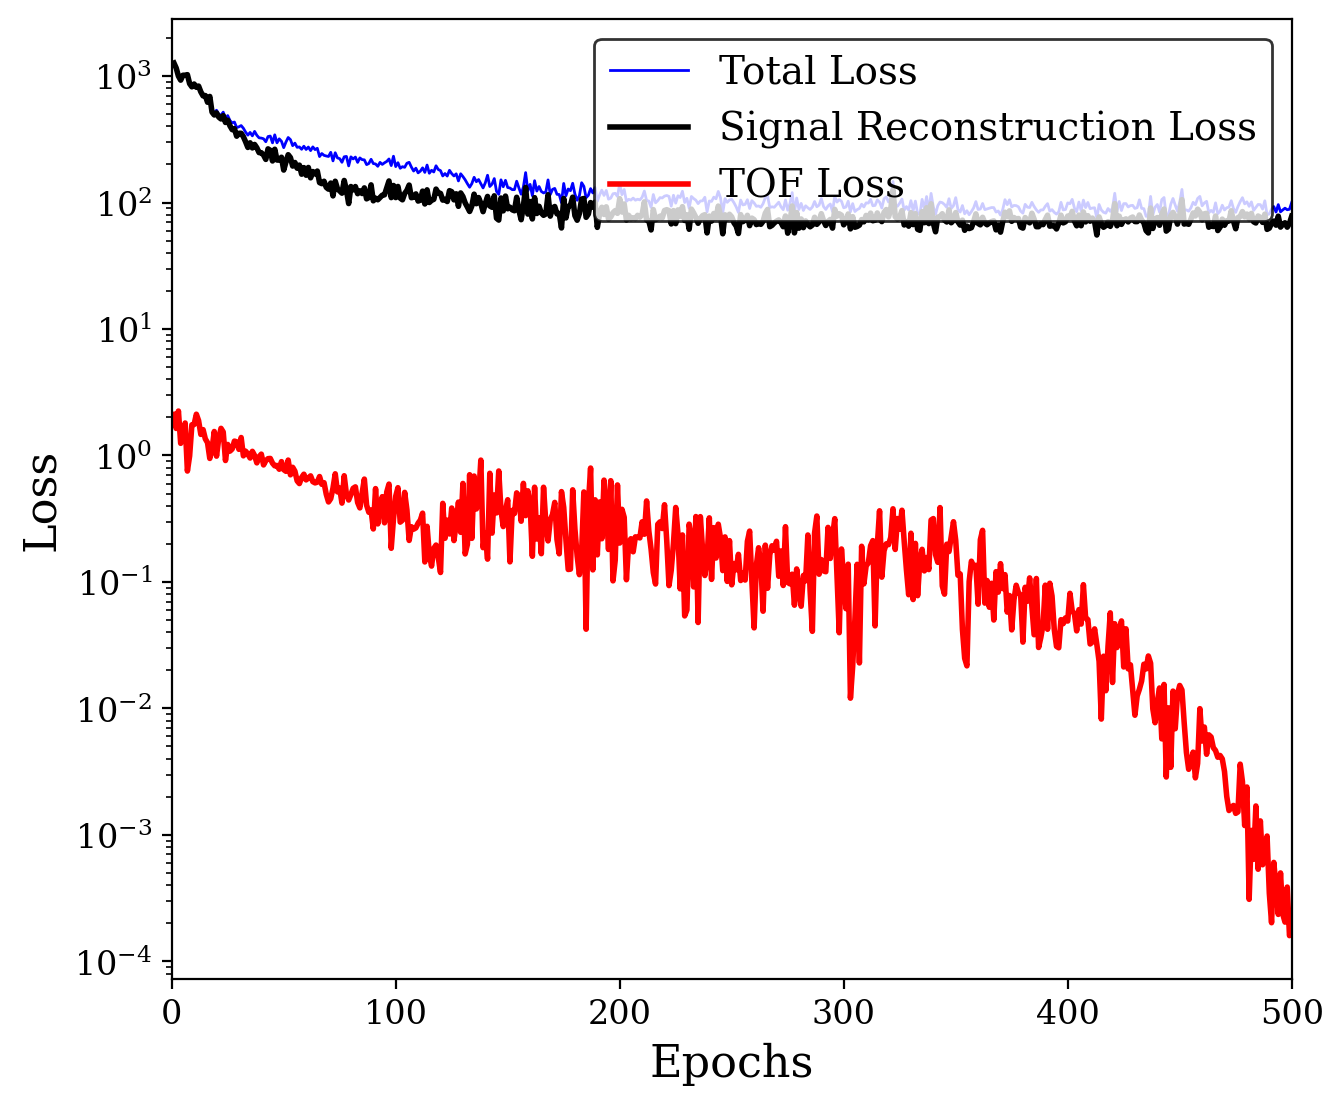

In [ ]:
nc = 1; nr = 1;
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(7*nc,6*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.2,hspace=0.5)

epoNum = np.arange(1,max_epochs+1)
plt.plot(epoNum,train_loss,'-b',linewidth = 1,label='Total Loss')
plt.plot(epoNum,signal_loss_list,'-k',linewidth = 2,label='Signal Reconstruction Loss')
plt.plot(epoNum,TOF_loss_list,'-r',linewidth = 2,label='TOF Loss')

ax.legend(loc='upper right',edgecolor='k',fontsize=14,frameon=True,ncol=1)
ax.set_xlabel('Epochs',fontsize=16)
ax.set_ylabel('Loss',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlim([0, max_epochs])
#ax.set_ylim([0, 10])
plt.yscale('log')
plt.rcdefaults()

In [ ]:
# plot the output vs ground truth

The concentration is 0.9621922386558996%


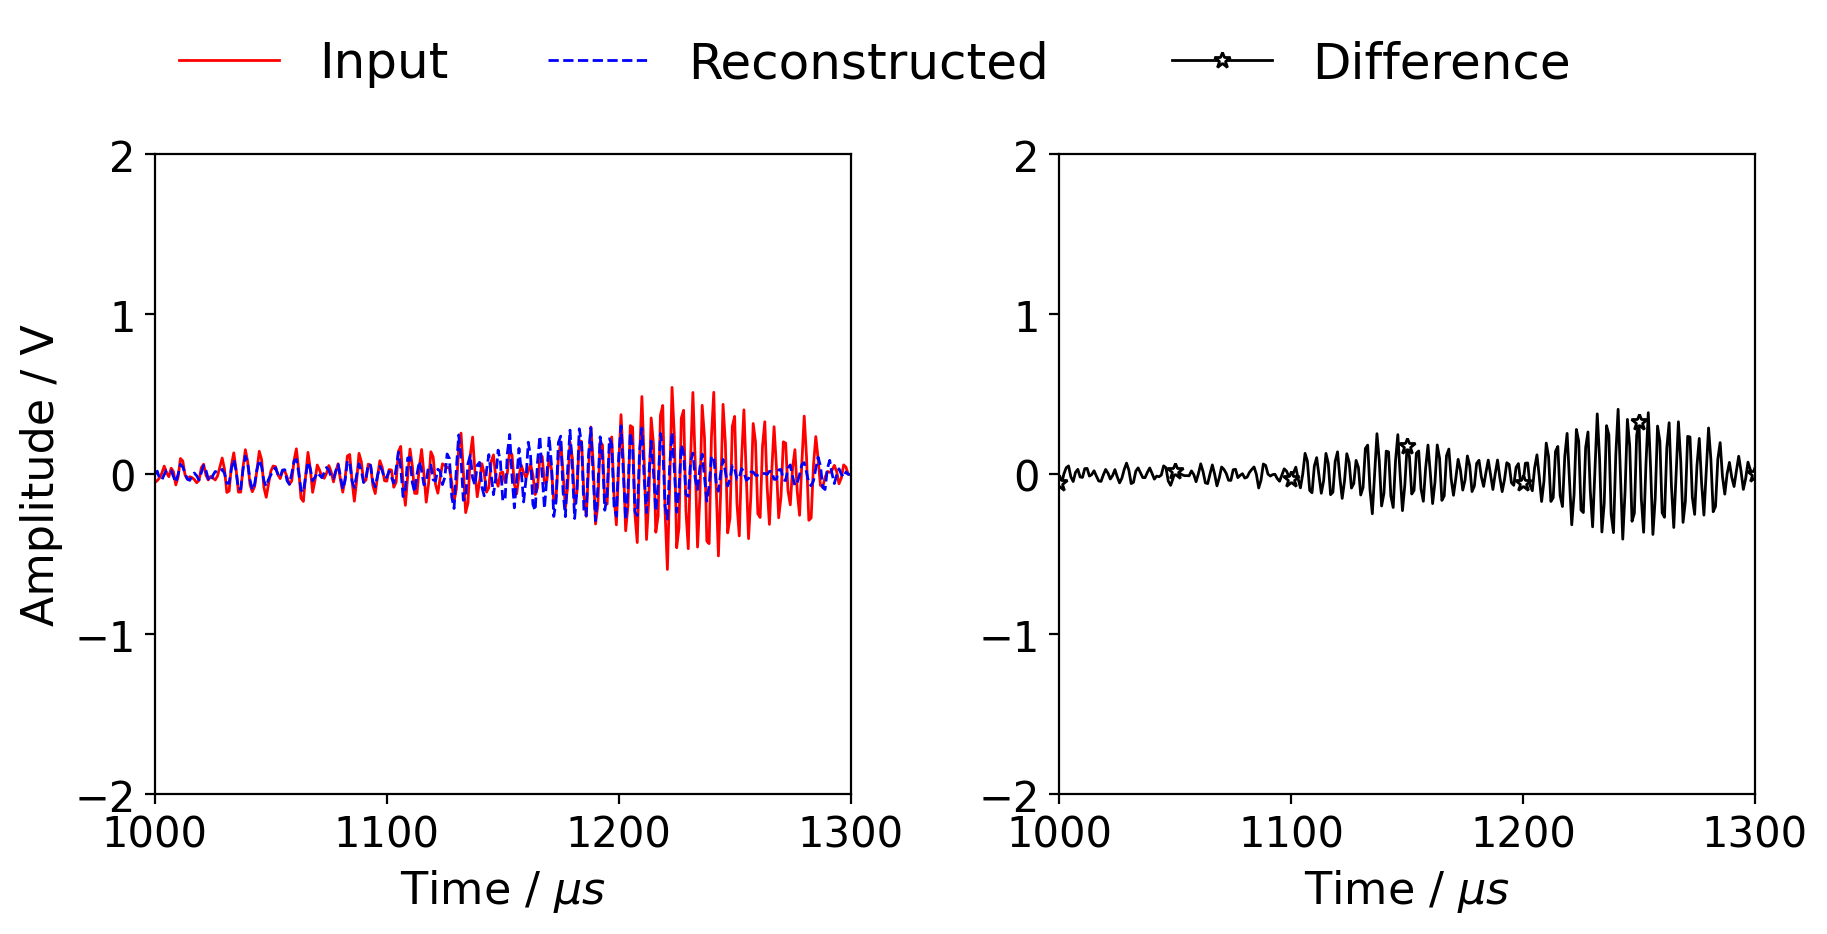

In [ ]:
nr = 1
nc = 2

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
#plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(5*nc,4*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)
ax = ax.flatten()

#Signal_used = X_train_with_TOF[700:701]
concen_idx = 25
Signal_used = impurity_data_argon[f'Impurity_Argon_{concen_idx}']

for idx in range(nr*nc):
  if idx%2 == 0:
    Wave_idx = np.random.randint(Signal_used.shape[0])
    with torch.no_grad():
      test_inputs_branch = torch.from_numpy(Signal_used[Wave_idx:Wave_idx+1]).to(torch.float32).to(device)
      #test_inputs_branch = torch.reshape(test_inputs_branch, (test_inputs_branch.size(dim=0), 1, 301))
      test_prediction = vae(test_inputs_branch)[0].cpu().detach().numpy()

    ax[idx].plot(Time_response*1e6,Signal_used[Wave_idx:Wave_idx+1,:-1].reshape(-1,1),'r',linewidth = 1,label='Input')
    ax[idx].plot(Time_response*1e6,test_prediction[:,:-1].reshape(-1,1),'--b',linewidth = 1,label='Reconstructed')
    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(1000,1300);ax[idx].set_ylim(-2,2)
    ax[nr*nc-2].legend(bbox_to_anchor=(1.35, 1.25),edgecolor='k',fontsize=18,frameon=False,ncol=2)
    if idx%4 == 0:
      ax[idx].set_ylabel('Amplitude / V',fontsize=16)

  else:
    Difference = Signal_used[Wave_idx:Wave_idx+1,:-1].reshape(-1,1)-test_prediction[:,:-1].reshape(-1,1)
    ax[idx].plot(Time_response*1e6,Difference,'-*k',markevery=50,markerfacecolor='w',linewidth = 1,label='Difference')
    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(1000,1300);ax[idx].set_ylim(-2,2)
    #ax[idx].legend(loc='lower right',edgecolor='k',fontsize=14,frameon=True,ncol=1)
    #Wave_idx += 1
print(f'The concentration is {Argon_Percentage[concen_idx][0]}%')
plt.legend(bbox_to_anchor=(0.8, 1.25),edgecolor='k',fontsize=18,frameon=False,ncol=1)

In [ ]:
plt.figure(figsize=(5,4),dpi=150)

concen_idx = 16
Signal_used = impurity_data_argon[f'Impurity_Argon_{concen_idx}']

with torch.no_grad():
  test_inputs_branch = torch.from_numpy(Signal_used).to(torch.float32).to(device)
  test_inputs_branch = torch.reshape(test_inputs_branch, (test_inputs_branch.size(dim=0), 1, 301))
  test_prediction = vae(test_inputs_branch)[0].cpu().detach().numpy()

#mse_errors = np.mean((test_prediction - Signal_used)**2, axis=1)
mae_errors = np.mean(np.abs(test_prediction - Signal_used), axis=1)

kwargs = dict(alpha=0.5, bins=100)
plt.hist(mae_errors, **kwargs,color = 'r',label='Argon',density=True)
plt.xlabel('Reconstruction Error', fontsize=14)
plt.ylabel('PDF', fontsize=14)

plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#plt.ylim(0,200)
#plt.xlim(0,5e-2)

plt.show()

In [ ]:
plt.figure(figsize=(5,4),dpi=150)  # Figure size

mean_list = []; std_list = []
with torch.no_grad():
  test_inputs_branch = torch.from_numpy(X_train).to(torch.float32).to(device)
  test_inputs_branch = torch.reshape(test_inputs_branch, (test_inputs_branch.size(dim=0), 1, 301))
  test_prediction = vae(test_inputs_branch)[0].cpu().detach().numpy()

kwargs = dict(alpha=0.5, bins=100)

#mse_errors = np.mean((test_prediction - X_train)**2, axis=1)
mae_errors = np.mean(np.abs(test_prediction - X_train), axis=1)

mean_list.append(np.mean(mae_errors))
std_list.append(np.std(mae_errors))

plt.hist(mae_errors, **kwargs,color = 'b',label='Argon',density=True)
plt.xlabel('Reconstruction Error', fontsize=14)
plt.ylabel('PDF', fontsize=14)

plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(0,0))

#plt.ylim(0,2500)
#plt.xlim(0,5e-3)
plt.show()

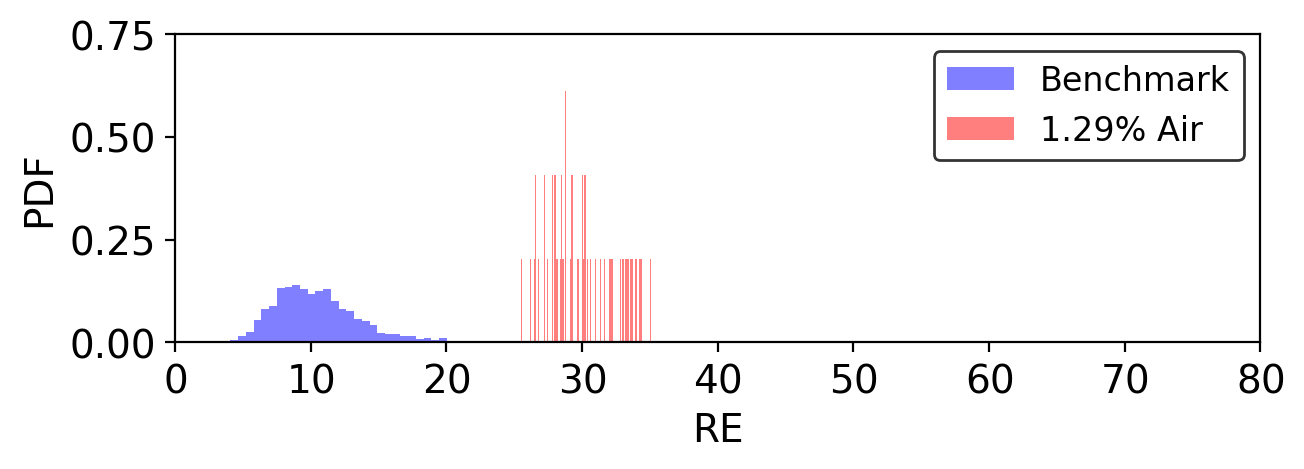

In [ ]:
plt.figure(figsize=(7,2),dpi=200)  # Figure size
alpha = 2e3

with torch.no_grad():
    test_inputs_branch = torch.from_numpy(X_train_with_TOF).to(torch.float32).to(device)
    test_inputs_branch = torch.reshape(test_inputs_branch, (test_inputs_branch.size(dim=0), 1, 302))
    test_prediction = vae(test_inputs_branch)[0].cpu().detach().numpy()

kwargs = dict(alpha=0.5, bins=100)

signal_mae_errors = np.sum(np.abs(test_prediction[:,:-1] - X_train_with_TOF[:,:-1]), axis=1)
TOF_MSE_errors = (test_prediction[:,-1] - X_train_with_TOF[:,-1])**2

total_errors = signal_mae_errors + alpha * TOF_MSE_errors

plt.hist(total_errors, **kwargs,color = 'b',label='Benchmark',density=True)

## plot impurity
concen_idx = 40
Signal_used = impurity_data_air[f'Impurity_Air_{concen_idx}']

with torch.no_grad():
    test_inputs_branch = torch.from_numpy(Signal_used).to(torch.float32).to(device)
    test_inputs_branch = torch.reshape(test_inputs_branch, (test_inputs_branch.size(dim=0), 1, 302))
    test_prediction = vae(test_inputs_branch)[0].cpu().detach().numpy()

signal_mae_errors = np.sum(np.abs(test_prediction[:,:-1] - Signal_used[:,:-1]), axis=1)
TOF_MSE_errors = (test_prediction[:,-1] - Signal_used[:,-1])**2

total_errors = signal_mae_errors + alpha * TOF_MSE_errors

kwargs = dict(alpha=0.5, bins=100)
plt.hist(total_errors, **kwargs,color = 'r',label=f'{Air_Percentage[concen_idx][0]:.2f}% Air',density=True)
plt.xlabel('RE', fontsize=14)
plt.ylabel('PDF', fontsize=14)

plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.legend(loc='upper right',edgecolor='k',fontsize='large',frameon=True,ncol=1)
plt.tick_params(axis='both', labelsize=14)
plt.xlim(0,80)
plt.ylim(0,0.75)
plt.show()

USE VAE to generate new data similar to Training set

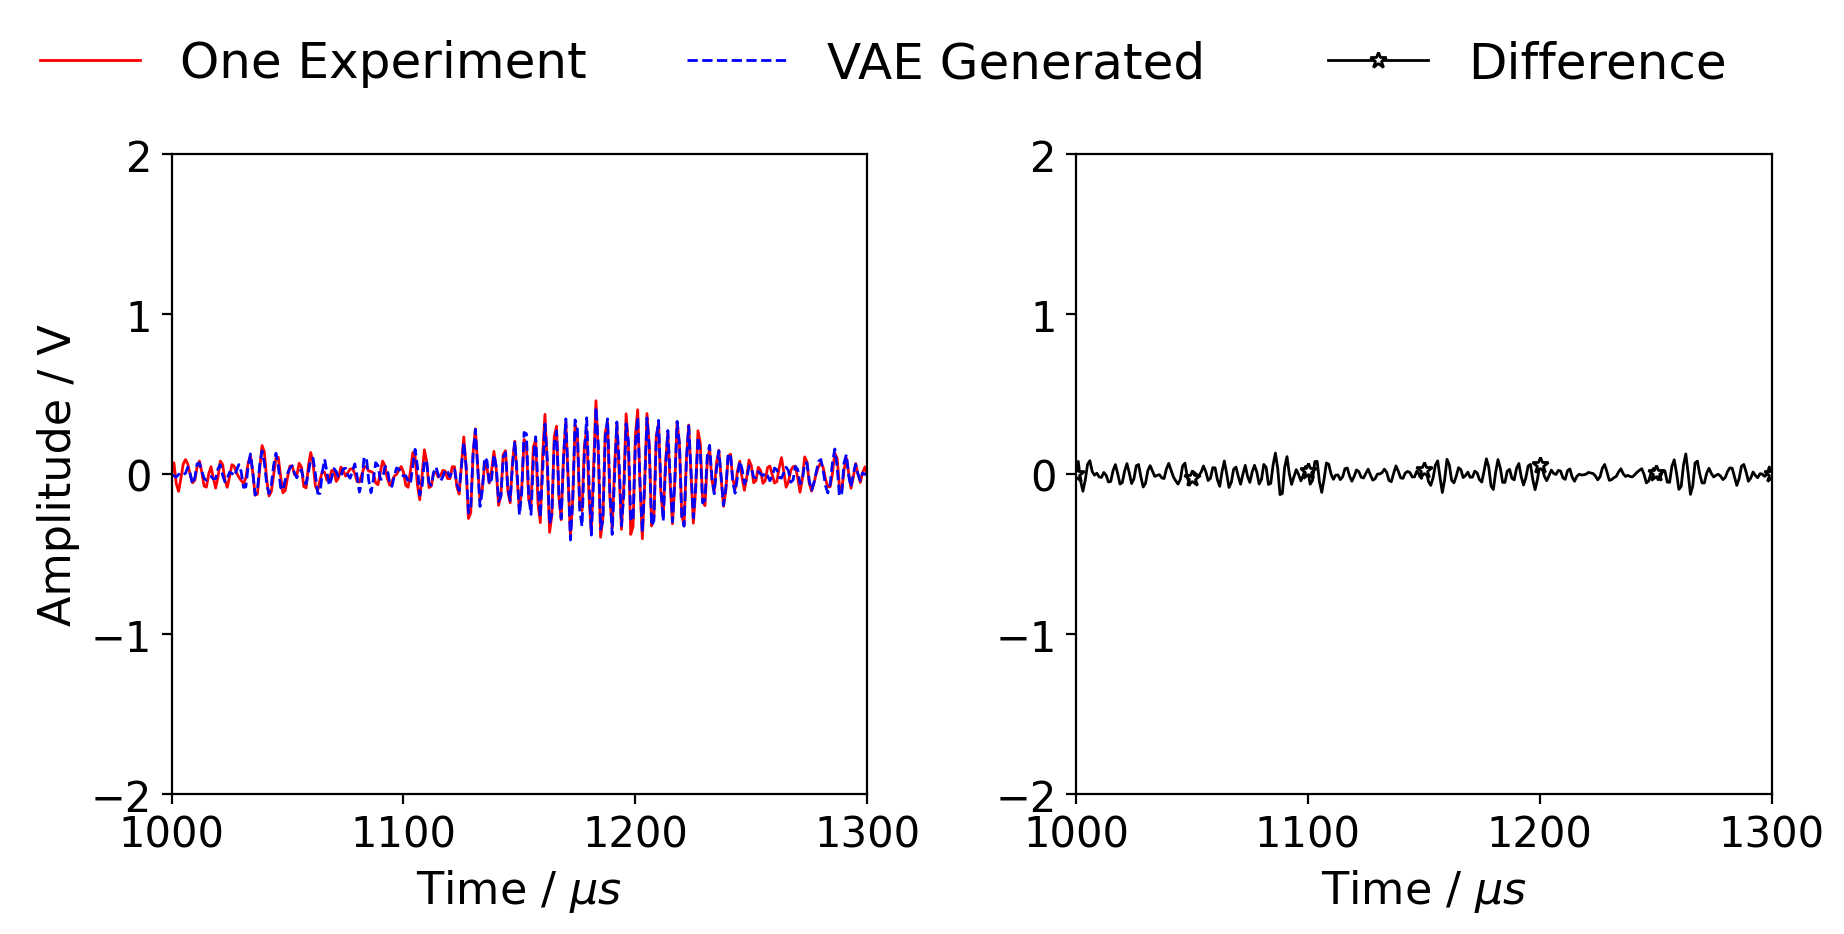

In [ ]:
num_samples = 1000  # You can change this as needed

# Assuming the latent space is a Gaussian with mean 0 and variance 1
z = torch.randn(num_samples, 10).to(device)
z[:, 8] += 1

# Decode the sample
with torch.no_grad():
    generated_data = vae.decode(z).cpu().numpy()
    averaged_data = np.mean(generated_data, axis=0)

nr = 1
nc = 2

plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
#plt.rc('font',**{'family':'serif','serif':['Times']})
fig, ax  = plt.subplots(nr,nc,figsize=(5*nc,4*nr),dpi=200)
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.4)
ax = ax.flatten()

experiments = X_train_with_TOF[800,:]
VAE_data = averaged_data #generated_data[50]

for idx in range(nr*nc):
  if idx%2 == 0:
    ax[idx].plot(Time_response*1e6,experiments[:-1],'r',linewidth = 1,label='One Experiment')
    ax[idx].plot(Time_response*1e6,VAE_data[:-1],'--b',linewidth = 1,label='VAE Generated')

    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(1000,1300);ax[idx].set_ylim(-2,2)
    ax[nr*nc-2].legend(bbox_to_anchor=(1.55, 1.25),edgecolor='k',fontsize=18,frameon=False,ncol=2)
    if idx%4 == 0:
      ax[idx].set_ylabel('Amplitude / V',fontsize=16)

  else:
    Difference = experiments[:-1]-VAE_data[:-1]
    ax[idx].plot(Time_response*1e6,Difference,'-*k',markevery=50,markerfacecolor='w',linewidth = 1,label='Difference')
    ax[idx].set_xlabel('Time / $\mu s$',fontsize=16);ax[idx].set_xlim(1000,1300);ax[idx].set_ylim(-2,2)

plt.legend(bbox_to_anchor=(1, 1.25),edgecolor='k',fontsize=18,frameon=False,ncol=1)

In [ ]:
def FindRE_Mean_and_std(Signal_used):
    with torch.no_grad():
        test_inputs_branch = torch.from_numpy(Signal_used).to(torch.float32).to(device)
        test_inputs_branch = torch.reshape(test_inputs_branch, (test_inputs_branch.size(dim=0), 1, 302))
        test_prediction = vae(test_inputs_branch)[0].cpu().detach().numpy()

    #signal_mse_errors = np.mean((test_prediction - Signal_used)**2, axis=1)
    signal_mae_errors = np.sum(np.abs(test_prediction[:,:-1] - Signal_used[:,:-1]), axis=1)

    TOF_MSE_errors = (test_prediction[:,-1] - Signal_used[:,-1])**2
    #TOF_mae_errors = np.abs(test_prediction[:,-1] - Signal_used[:,-1])

    total_mae_errors = signal_mae_errors + alpha * TOF_MSE_errors

    return np.mean(total_mae_errors),np.std(total_mae_errors),np.mean(signal_mae_errors),np.std(signal_mae_errors),np.mean(alpha*TOF_MSE_errors),np.std(alpha*TOF_MSE_errors)

In [ ]:
alpha = 2e3

mean_list = []; std_list = []

Signal_used = X_train_with_TOF[:]
mean_list.append(FindRE_Mean_and_std(Signal_used)[0])
std_list.append(FindRE_Mean_and_std(Signal_used)[1])

for i in range(1, 41):  # Loop from 1 to 40
    Signal_used = impurity_data_air[f'Impurity_Air_{i}']
    #Signal_used = impurity_data_argon[f'Impurity_Argon_{i}']
    mean_list.append(FindRE_Mean_and_std(Signal_used)[0])
    std_list.append(FindRE_Mean_and_std(Signal_used)[1])

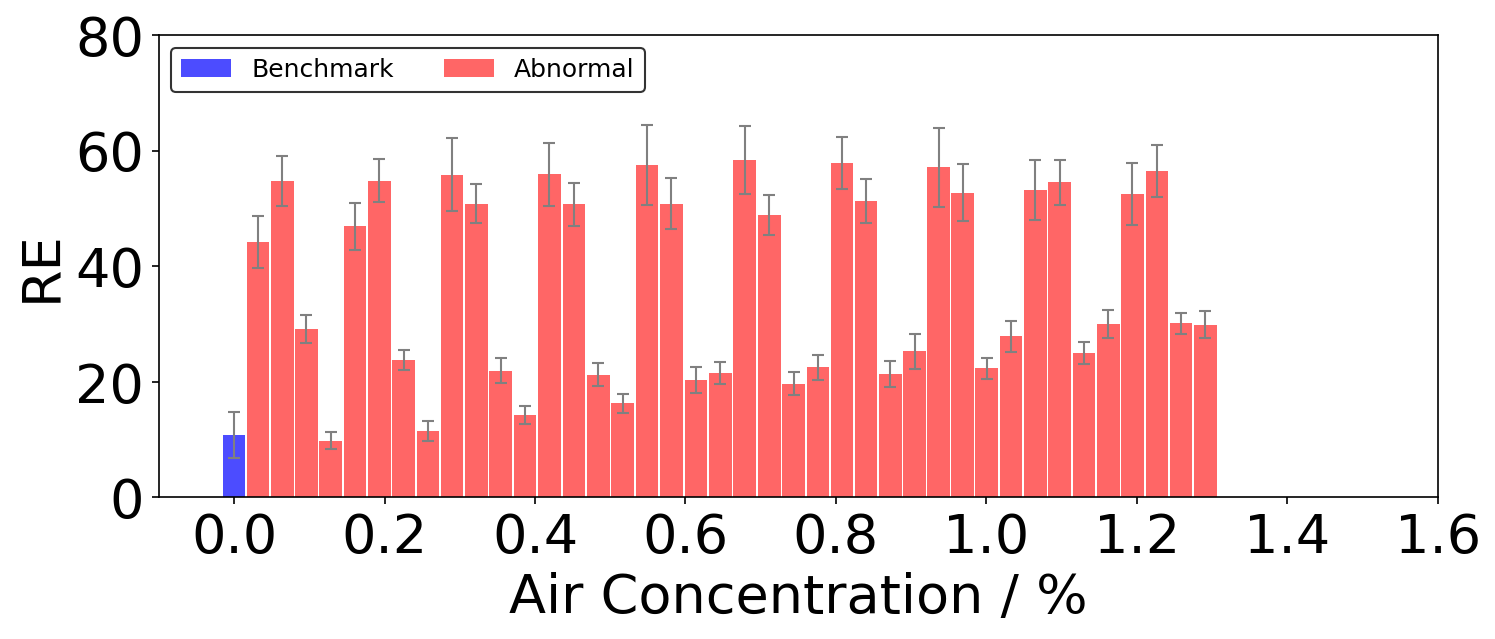

In [ ]:
plt.figure(figsize=(11, 4), dpi=150)
label_for_benchmark_added = False
label_for_impurities_added = False

# Creating a bar chart with error bars
for i in range(len(mean_list)):
    if i == 0:
        # First bar in blue
        plt.bar(Air_Percentage[i], mean_list[i], yerr=std_list[i:i+1], capsize=3, alpha=0.7, width=0.03,
                color='b', edgecolor='b', linewidth=0,
                error_kw={'elinewidth': 1, 'ecolor': 'grey'},label='Benchmark' if not label_for_benchmark_added else '')
        label_for_benchmark_added = True
    else:
        # Other bars in a different color
        plt.bar(Air_Percentage[i], mean_list[i], yerr=std_list[i:i+1], capsize=3, alpha=0.6, width=0.03,
                color='r', edgecolor='r', linewidth=0,
                error_kw={'elinewidth': 1, 'ecolor': 'grey'},label='Abnormal' if not label_for_impurities_added else '')
        label_for_impurities_added = True

# Setting labels and title
plt.xlabel('Air Concentration / %', fontsize=26)
plt.ylabel('RE', fontsize=26)
plt.legend(loc='upper left', edgecolor='k', fontsize='large', frameon=True, ncol=2)
plt.xlim(-0.1, 1.6)
plt.ylim(0, 80)  # Adjust y-axis limit to fit the data
#plt.yticks(np.arange(0, 0.3, 0.05))
plt.xticks(np.arange(0, 1.8, 0.2))
plt.tick_params(axis='both', labelsize=26)
plt.show()

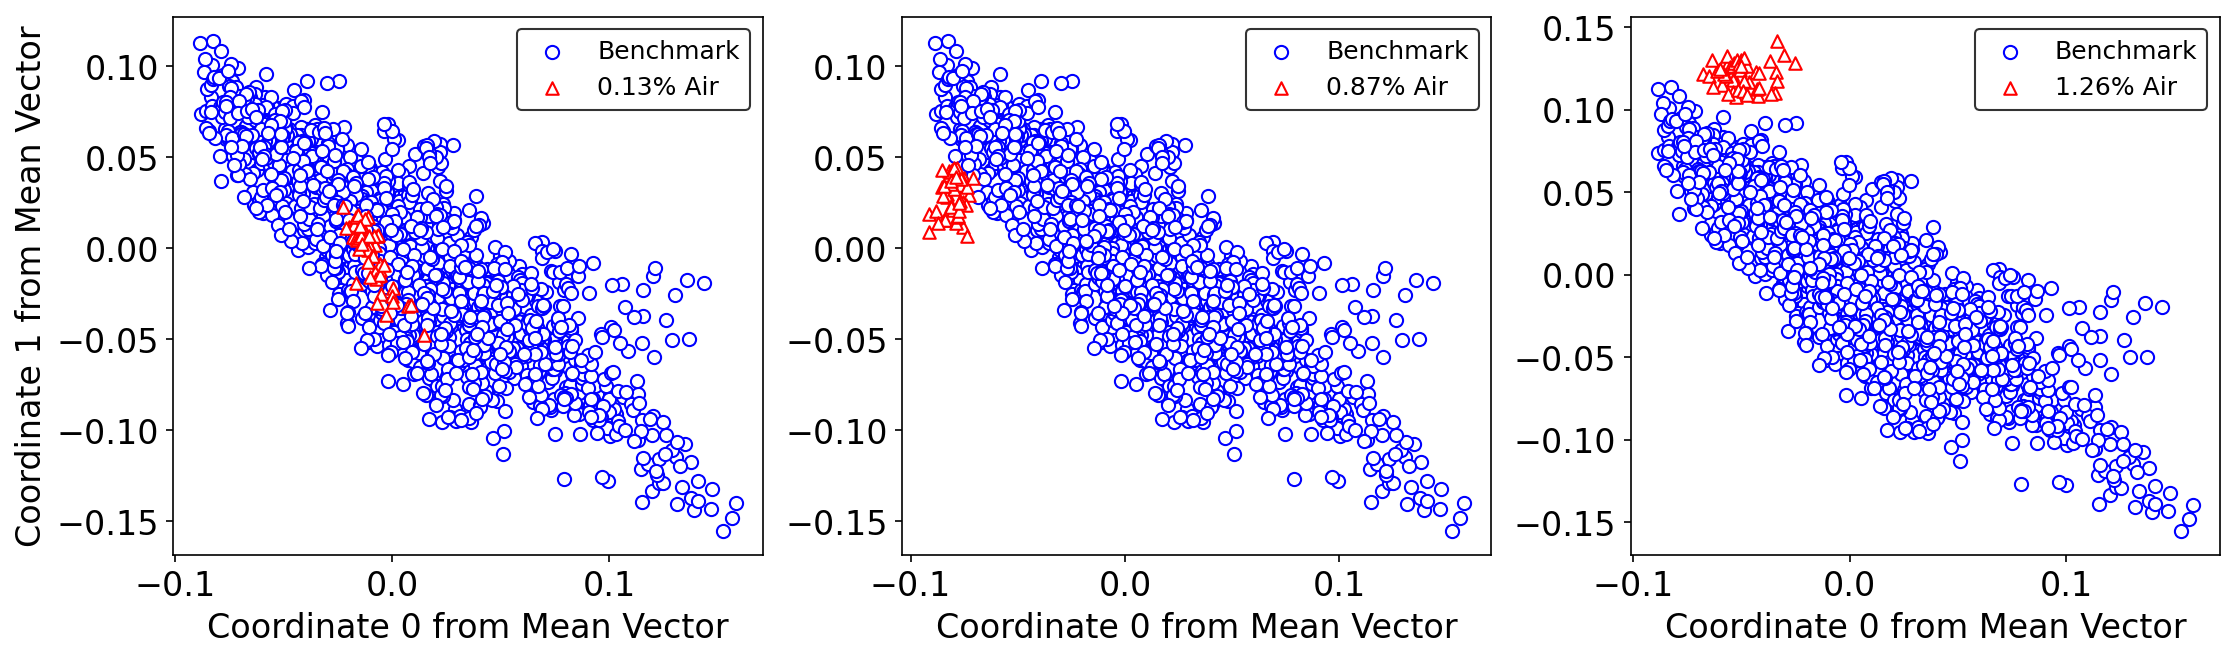

In [ ]:
plt.figure(figsize=(15, 4.5), dpi=150)

Node_idx_1 = 0
Node_idx_2 = 1

for index, i in enumerate([4, 27, 39], start=1):
    #impure_signal = impurity_data_argon[f'Impurity_Argon_{i}']
    impure_signal = impurity_data_air[f'Impurity_Air_{i}']

    # Encode the impure signal to latent space without gradient calculations
    with torch.no_grad():
        mu, _ = vae.encode(torch.Tensor(impure_signal))  # Only use the means
        latent_signal_used = mu.numpy()

    if index == 1:  # Check if it's the first iteration
        with torch.no_grad():
            mu, _ = vae.encode(torch.Tensor(X_train_with_TOF[:]))  # Only use the means
            latent_X_train = mu.numpy()

    plt.subplot(1, 3, index)
    plt.scatter(latent_X_train[:, Node_idx_1], latent_X_train[:, Node_idx_2], edgecolors='b', facecolors='white', s=40, label='Benchmark')

    plt.scatter(latent_signal_used[:, Node_idx_1], latent_signal_used[:, Node_idx_2], marker='^', edgecolors='r', facecolors='white', label=f'{Air_Percentage[i][0]:.2f}% Air')
    plt.legend(loc='upper right', edgecolor='k', fontsize='large', frameon=True, ncol=1)

    #plt.xlim(-0.3, 0.2)
    #plt.ylim(-3, 2)
    plt.xlabel(f'Coordinate {Node_idx_1} from Mean Vector', fontsize=16)
    if index==1:
      plt.ylabel(f'Coordinate {Node_idx_2} from Mean Vector', fontsize=16)
    plt.tick_params(axis='both', labelsize=16)

plt.tight_layout()  # Adjust the layout

plt.show()

In [ ]:
np.mean(latent_X_train,axis=0)

array([ 0.00497369, -0.0027544 , -0.00298656, -0.01142202, -0.0125191 ,
        0.00484795, -0.00467109, -0.00790694, -0.01041964,  0.03304125],
      dtype=float32)

<ipython-input-27-e2da85494112>:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, Argon_Percentage[40][0], 8))


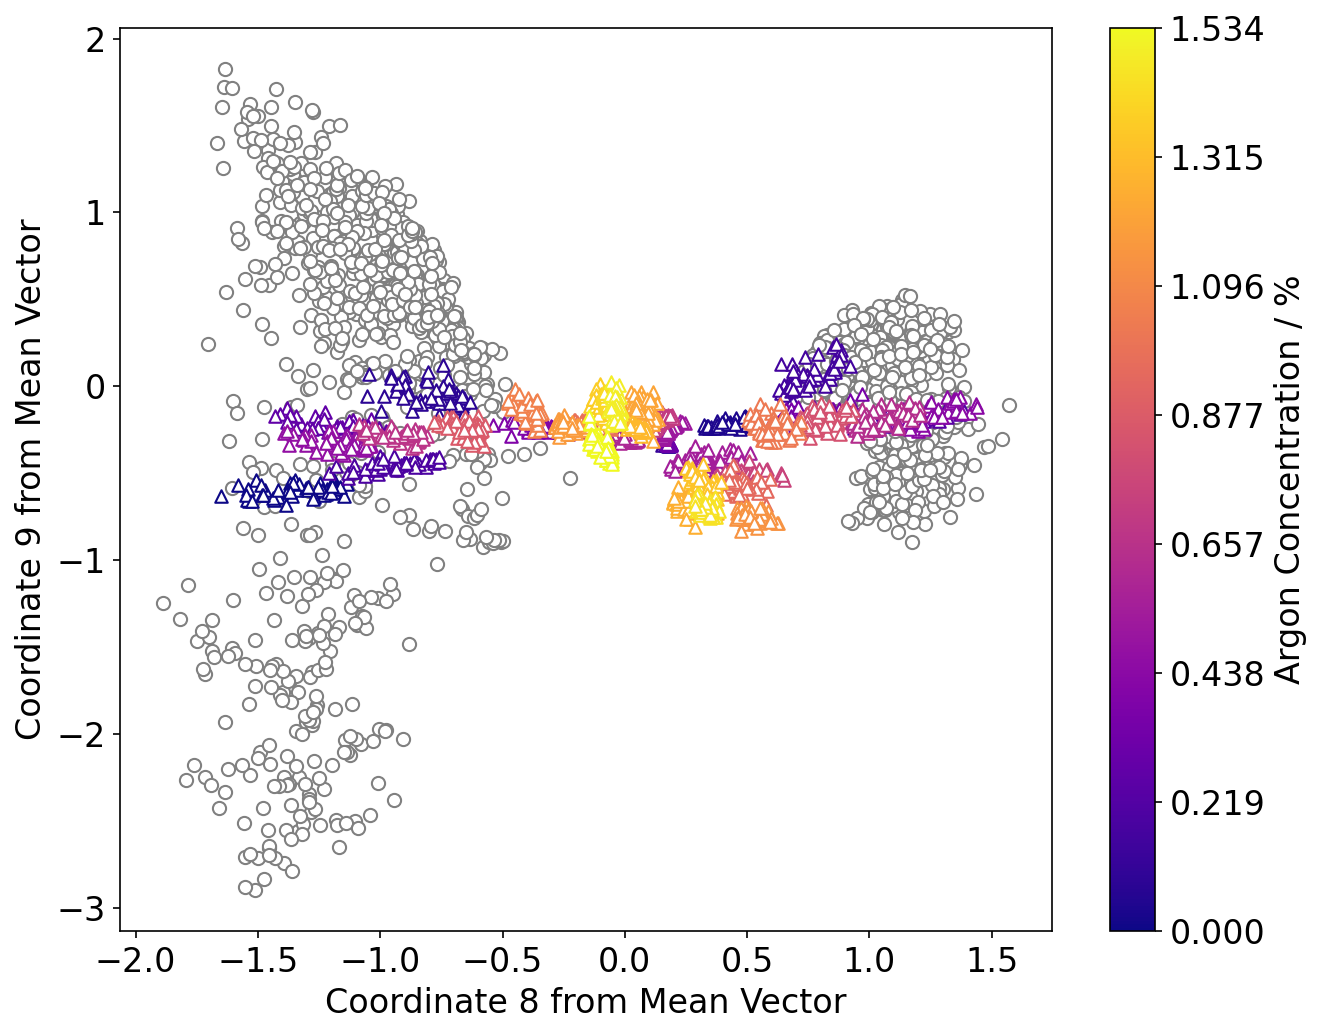

In [ ]:
plt.figure(figsize=(9, 7), dpi=150)
Node_idx_1 = 8
Node_idx_2 = 9
colors = plt.cm.plasma(np.linspace(0, 1, 40))  # Gradient color map

with torch.no_grad():
    mu, _ = vae.encode(torch.Tensor(X_train_with_TOF[:]))  # Only use the means
    latent_X_train = mu.numpy()

    plt.scatter(latent_X_train[:, Node_idx_1], latent_X_train[:, Node_idx_2],
              edgecolors='grey', facecolors='white', s=40, label='Benchmark')

for i in range(1, 41):
    impure_signal = impurity_data_argon[f'Impurity_Argon_{i}']
    #impure_signal = impurity_data_air[f'Impurity_Air_{i}']

    # Assume the VAE and the following operations are correctly defined
    with torch.no_grad():
        mu, _ = vae.encode(torch.Tensor(impure_signal))  # Only use the means
        latent_signal_used = mu.numpy()

    plt.scatter(latent_signal_used[:, Node_idx_1], latent_signal_used[:, Node_idx_2],
            marker='^', edgecolors=colors[i-1], facecolors='white',
            label='Air')

sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=Argon_Percentage[0][0], vmax=Argon_Percentage[40][0]))
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, Argon_Percentage[40][0], 8))
cbar.set_label('Argon Concentration / %', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.xlabel(f'Coordinate {Node_idx_1} from Mean Vector', fontsize=16)
plt.ylabel(f'Coordinate {Node_idx_2} from Mean Vector', fontsize=16)
plt.tick_params(axis='both', labelsize=16)
#plt.legend(loc='upper right', edgecolor='k', fontsize='large', frameon=True, ncol=1)
#plt.xlim(-2, 2)
#plt.ylim(-1, 1.5)
#plt.ylim(-3, 2)
plt.tight_layout()
plt.show()

In [ ]:
with torch.no_grad():
  test_1, _ = vae.encode(torch.Tensor(X_train[:]))
  test_1 = test_1.numpy()

  #test_2, _ = vae.encode(torch.Tensor(X_train[503:]))
  #test_2 = test_2.numpy()

print(test_1.shape,test_2.shape)
import itertools
dimension_pairs = list(itertools.combinations(range(5), 2))

# Initialize an array to hold the centroid distances
centroid_distances = []

# Calculate centroids and their distances
for pair in dimension_pairs:
    centroid_1 = np.mean(test_1[:, [pair[0], pair[1]]], axis=0)
    centroid_2 = np.mean(test_2[:, [pair[0], pair[1]]], axis=0)
    distance = np.linalg.norm(centroid_1 - centroid_2)
    centroid_distances.append(distance)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(centroid_distances, bins=30, alpha=0.7, color='b')
plt.xlabel('Centroid Distance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of Centroid Distances')
plt.show()

In [ ]:
plt.scatter(np.arange(10),centroid_distances)

In [ ]:
num_samples_per_point = 1000
Node_idx_1 = 2
colors = ['grey','b','r']
colors = ['#FFCCCC', '#FF6666', '#FF0000']
styles = ['-','--','-.']

# Prepare the plot
plt.figure(figsize=(6, 5), dpi=150)

# Loop over the selected impurity levels
for index, i in enumerate([4, 27, 39], start=0):
    #impure_signal = impurity_data_argon[f'Impurity_Argon_{i}']
    impure_signal = impurity_data_air[f'Impurity_Air_{i}']

    # Encode the impure signal to latent space
    with torch.no_grad():
        mu, logvar = vae.encode(torch.Tensor(impure_signal))
        std = torch.exp(0.5 * logvar)
        mu = mu.numpy()
        std = std.numpy()

    # Initialize an empty list to store samples
    all_samples = []

    # Sample from the Gaussian distribution for each data point
    for mu_val, std_val in zip(mu[:, Node_idx_1], std[:, Node_idx_1]):
        samples = np.random.normal(loc=mu_val, scale=std_val, size=num_samples_per_point)
        all_samples.append(samples)

    # Flatten the list of samples
    all_samples_flat = np.concatenate(all_samples)

    # Create a range of values for the x-axis
    min_val, max_val = min(all_samples_flat), max(all_samples_flat)
    x_axis = np.linspace(min_val, max_val, 1000)

    # Create a Gaussian curve for this set of samples
    final_mean = np.mean(all_samples_flat)
    final_std = np.std(all_samples_flat)
    pdf = norm.pdf(x_axis, final_mean, final_std)
    print(f'Mean = {final_mean},std = {final_std}')
    # Plot the Gaussian curve
    plt.plot(x_axis, pdf, label=f'{Air_Percentage[i][0]:.2f}% Air',color = colors[index],linestyle = styles[index])

# Finalize the plot
plt.xlabel(f'Coordinate {Node_idx_1} after Reparameterization', fontsize=16)
plt.ylabel('Gaussian PDF', fontsize=16)
#plt.ylim(0,0.5)
plt.xlim(-4,4)
plt.tick_params(axis='both', labelsize=16)
plt.legend(loc='upper right',edgecolor='k', fontsize='large', frameon=True)
plt.show()

In [ ]:
l2_norms_mean = []
l2_norms_std = []

Signal_used = X_train[:]

#i = 10
#Signal_used = impurity_data_air[f'Impurity_Air_{i}']

with torch.no_grad():
    mu, logvar = vae.encode(torch.Tensor(Signal_used))
    std = torch.exp(0.5 * logvar)
    mu = mu.numpy()
    std = std.numpy()

    # Calculate L2 norm and store in the list
    l2_norm = np.linalg.norm(mu,axis=1)

    l2_norms_mean.append(np.mean(l2_norm))
    l2_norms_std.append(np.std(l2_norm))

In [ ]:
plt.plot(mu[:,4])

In [ ]:
idx = 2

plt.figure(figsize=(6, 5),dpi=150)
plt.hist(mu[:,idx], bins=30, color='lightblue',label='Test 1 Benchmark')
#plt.hist(mu[503:,idx], bins=30, color='darkred',label='Test 2 Benchmark')
plt.xlabel(f'Coordinate {idx} in Mean Vector', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
#plt.ylim(0,60)
#plt.xlim(-0.1,0.1)
plt.legend(loc='upper left',edgecolor='k', fontsize='large', frameon=True)
plt.tick_params(axis='both', labelsize=16)
plt.show()

In [ ]:
l2_norms_mean = []
l2_norms_std = []

Signal_used = X_train_with_TOF[:]

with torch.no_grad():
    mu, _ = vae.encode(torch.Tensor(Signal_used))
    mu = mu.numpy()

    # Calculate L2 norm and store in the list
    mu_copy = np.delete(mu, 5, axis=1)
    l2_norm = np.linalg.norm(mu_copy,axis=1)

    l2_norms_mean.append(np.mean(l2_norm))
    l2_norms_std.append(np.std(l2_norm))

for i in range(1, 41):
    impure_signal = impurity_data_argon[f'Impurity_Argon_{i}']

    # Encode the impure signal to latent space
    with torch.no_grad():
        mu, _ = vae.encode(torch.Tensor(impure_signal))
        mu = mu.numpy()

        # Calculate L2 norm and store in the list
        mu_copy = np.delete(mu, 5, axis=1)
        l2_norm = np.linalg.norm(mu_copy,axis=1)

        l2_norms_mean.append(np.mean(l2_norm))
        l2_norms_std.append(np.std(l2_norm))

RuntimeError: ignored

In [ ]:
plt.figure(figsize=(6,5),dpi=150)

plt.errorbar(Argon_Percentage, l2_norms_mean, yerr=l2_norms_std, fmt='o', capsize=5,
             alpha=0.7,color='b', markerfacecolor='white', markeredgecolor='b',
             markeredgewidth=1, label='Mean with std.')

plt.xlabel('Impurity Concentration / %',fontsize=16)
plt.ylabel('Norm of Mean Vector (no coord. 5)',fontsize=16)
plt.legend(loc='upper right',edgecolor='k',fontsize='large',frameon=True,ncol=1)
plt.xlim(0,1.8)
plt.ylim(-0.005,1.2)
#plt.yticks(np.arange(0, 0.18, 0.03))
plt.xticks(np.arange(0, 2, 0.2))
plt.tick_params(axis='both', labelsize=16)
plt.show()

# Conventional TOF

In [ ]:
TOF_mean = [];TOF_std = []

max_amplitude_indices = np.argmax(X_train[:], axis=1)
TOF = Time_response[max_amplitude_indices] *1e3 # use this line for training VAE with TOF
#TOF = Time_response[max_amplitude_indices] *1e6
TOF_mean.append(np.mean(TOF))
TOF_std.append(np.std(TOF))

add TOF for training data

In [ ]:
TOF_reshaped = TOF.reshape((-1, 1))

# Append TOF as the last column to X_train
X_train_with_TOF = np.hstack((X_train, TOF_reshaped))
X_train_with_TOF.shape

(1991, 302)

In [ ]:
for i in range(1, 41):  # Loop from 1 to 40
    Signal_used = impurity_data_air[f'Impurity_Air_{i}']
    #Signal_used = impurity_data_argon[f'Impurity_Argon_{i}']
    max_amplitude_indices = np.argmax(Signal_used, axis=1)
    #TOF = Time_response[max_amplitude_indices] * 1e3 # use this line for training VAE with TOF
    TOF = Time_response[max_amplitude_indices] * 1e6
    TOF_mean.append(np.mean(TOF))
    TOF_std.append(np.std(TOF))

add TOF for impurities

In [ ]:
for i in range(1, 41):  # Loop from 1 to 40
    #Signal_used = impurity_data_air[f'Impurity_Air_{i}']
    Signal_used = impurity_data_argon[f'Impurity_Argon_{i}']
    max_amplitude_indices = np.argmax(Signal_used, axis=1)
    TOF = Time_response[max_amplitude_indices] * 1e3
    TOF_reshaped = TOF.reshape((-1, 1))
    Signal_with_TOF = np.hstack((Signal_used, TOF_reshaped))

    #impurity_data_air[f'Impurity_Air_{i}'] = Signal_with_TOF
    impurity_data_argon[f'Impurity_Argon_{i}'] = Signal_with_TOF

Text(0, 0.5, 'TOF Change / $\\mu s$')

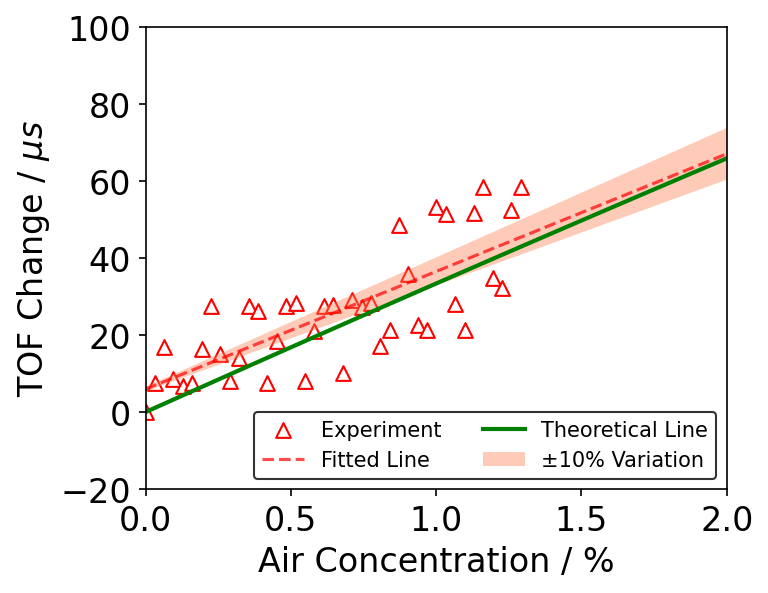

In [ ]:
from sklearn.linear_model import LinearRegression

delta_TOF = TOF_mean - TOF_mean[0]

plt.figure(figsize=(5,4),dpi=150)  # Figure size

c_values = np.linspace(0, 2, 100)  # 100 points between 0 and 1.5
cal_deltaTOF_values = [Cal_deltaTOF(0,c,294, 1066.8) for c in c_values]

valid_indices = np.where((Air_Percentage.squeeze() != 0) & ~np.isnan(Air_Percentage.squeeze()))[0]
m = np.mean(delta_TOF[valid_indices] / Air_Percentage.squeeze()[valid_indices])
y_fitted = m * np.array(Argon_Percentage)

# Reshape the data
X = Air_Percentage.reshape(-1, 1)
y = delta_TOF

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

predictions = model.predict(c_values.reshape((-1,1)))

# Plot the scatter plot
plt.scatter(Air_Percentage, delta_TOF, edgecolors='r', facecolors='white',marker='^', s=50, label = 'Experiment')
plt.plot(c_values, predictions, color='red',alpha=0.7,linestyle='--', label='Fitted Line')
plt.plot(c_values, cal_deltaTOF_values, '-g',linewidth=2, label='Theoretical Line')

cal_deltaTOF_values_plus_10percent = [1.1 * v for v in predictions]  # +10% confidence line
cal_deltaTOF_values_minus_10percent = [0.9 * v for v in predictions]  # -10% confidence line

# Adding the +10% and -10% error lines
plt.fill_between(c_values, cal_deltaTOF_values_minus_10percent, cal_deltaTOF_values_plus_10percent, color='coral', alpha=0.4,edgecolor=None,label='±10% Variation')

plt.legend(loc='lower right',edgecolor='k',fontsize='medium',frameon=True,ncol=2)
plt.xlim(0,2)
plt.ylim(-20,100)
plt.xticks(np.arange(0, 2.5, 0.5),fontsize=16)
plt.yticks(np.arange(-20, 120, 20),fontsize=16)
plt.xlabel('Air Concentration / %',fontsize=16)
plt.ylabel('TOF Change / $\mu s$',fontsize=16)

#plt.savefig('Air-scatters.svg',format='svg',bbox_inches = 'tight')